In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from os import listdir
import re

import scipy.integrate as integrate
from scipy.interpolate import interp1d as interp

import gc
matplotlib.rcParams.update({'font.size': 14})

In [2]:
c = 2.99792458 * 10 ** 8
hbar = 6.6 * 10 ** -16
hbar = hbar * 10 ** -9

eta = np.diag([1,-1,-1,-1])

In [3]:
c*hbar

1.9786302228000003e-16

In [4]:
# PDG Values

m_pi0 = 0.135 # GeV
m_eta = 0.548 # GeV
m_KL  = 0.497 # GeV
m_D   = 1.865 # GeV
m_b   = 4.180 # GeV
m_B   = 5.280 # GeV
m_mu  = 105.6583755 * 10 ** -3 # GeV
v     = 246 # GeV

tau_D = 4.101 * 10**-13 # s
tau_B = 1.519 * 10**-12 # s
tau_KL = 5.116 * 10**-8 # s
tau_eta = 5.04 * 10**-19 # s (Inverting width in PDG)
tau_pi0 = 8.43 * 10**-17 # s

# Branching ratios to invisible from various experiments

Br_pi0 = 10**-7   # 1409.2288
Br_KL  = 10**-4   # 1409.2288
Br_eta = 10**-4   # 1409.2288
Br_D   = 10**-5   # 1206.2543
Br_B   = 10**-5   # 1808.10567

In [5]:
# Import dark higgs parameters and make interpolating functions
data = np.genfromtxt('DarkHiggs/darkhiggs_decaylengths.csv', delimiter=',')
masses = data[:,0]
ctaus  = data[:,1]
f_ctaus = interp(masses, ctaus)

data = np.genfromtxt('DarkHiggs/darkhiggs_mubranching.csv', delimiter=',')
masses       = data[:,0]
mubranching  = data[:,1]
f_mubranching = interp(masses, mubranching)

In [6]:
dataset1 = np.load('Spectra/X_2.0_Y_0.497_from_bspectrum.npy')

In [7]:
dataset2 = np.genfromtxt('Spectra/bbbar_spectrum.csv',
                        delimiter=',', skip_header=1)

p_Bs   = dataset2[:,2]
thetas = dataset2[:,1]
xsecs  = dataset2[:,10]

# Silliness to fit conventions of the .npys
dataset2 = np.array([p_Bs, thetas, xsecs]).T

p_Bs_u   = np.sort(list(set(p_Bs)))
thetas_u = np.sort(list(set(thetas)))

In [8]:
def plot_B_spectra():

    cmap = matplotlib.colormaps['hsv']
    cmap.set_under('w')

    fig = plt.figure(figsize=(24,8))

    i=1
    datasets = [dataset2, dataset1, dataset1]
    titles = ['FONLL Output', 'Resummed Isotropic Decay', 'Resummed Weighted Decay']
    for (dataset, title) in zip(datasets, titles):
        p_Bs   = dataset[:,0]
        thetas = dataset[:,1]
        xsecs  = dataset[:,2]
        xsecs_logscaled = xsecs * p_Bs * thetas * np.log(10) ** 2
        if i == 3:
            theta_rs = dataset[:,3]
            phi_rs   = dataset[:,4]
            xsecs_logscaled = xsecs * p_Bs * thetas * np.log(10) ** 2
    #         xsecs_logscaled = xsecs_logscaled * theta_rs * phi_rs * np.log(10) ** 2
            xsecs_logscaled = xsecs_logscaled * np.sin(theta_rs) / 2
        xsecs_logscaled = xsecs_logscaled * 3 * 10 ** 6
        p_Bs_u   = np.sort(list(set(p_Bs)))
        thetas_u = np.sort(list(set(thetas)))

        p_bins = np.logspace(-2,4,31)
        theta_bins = np.logspace(-6,0,31)

        ax = plt.subplot(1,len(datasets),i)
        plt.sca(ax)
        plt.hist2d(thetas, p_Bs, bins=[theta_bins, p_bins],
                   weights = xsecs_logscaled,
                   cmap=cmap,
                   norm=matplotlib.colors.LogNorm(vmin=10**8.5,vmax=10**13.5))
        cax = ax.inset_axes([0.02, 0.02, 0.05, 0.6])
        plt.colorbar(cax=cax)
        plt.xscale('log')
        plt.yscale('log')
        plt.grid();
        plt.title(title)
        plt.xlabel('$\\theta_B$')
        if i == 1: plt.ylabel('$p_B$ [GeV]')
        i += 1
    return fig

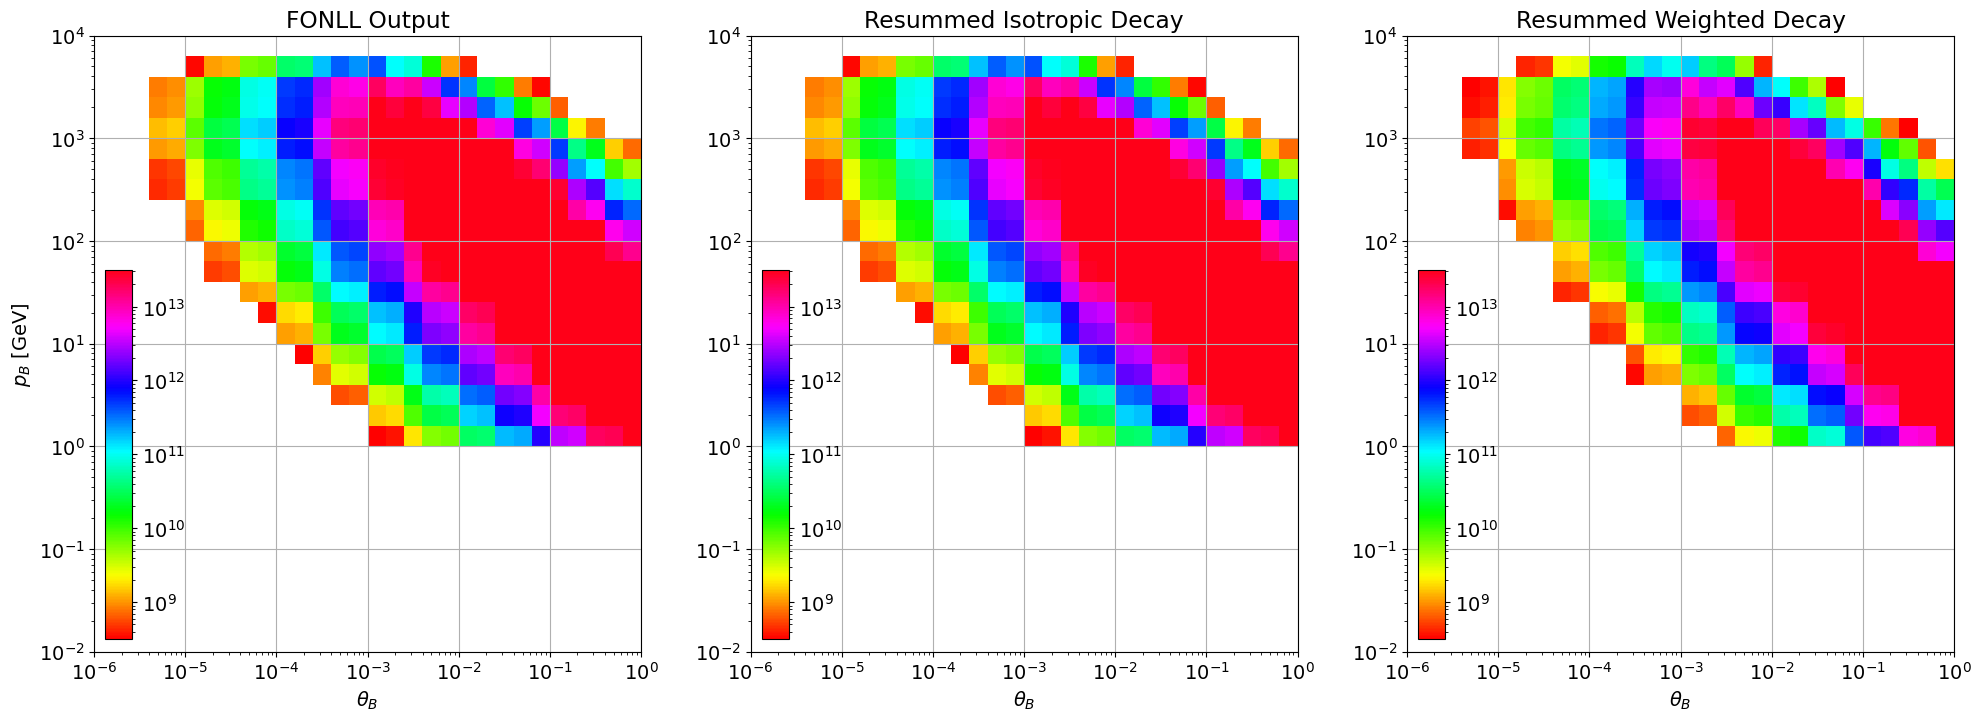

In [9]:
fig = plot_B_spectra();
fig.savefig('Plots/B_dist_comparison.pdf')

In [10]:
def plot_X_spectra(m_Xs, sin_scaled=False):
    m_Xs = np.array(m_Xs).T
    cmap = matplotlib.colormaps['hsv']
    cmap.set_under('w')
    width = 9
    height = 9
    try:
        nx, ny = np.shape(m_Xs)
    except ValueError:
        m_Xs = np.reshape(m_Xs, ( np.size(m_Xs), 1 ))
        nx, ny = np.shape(m_Xs)

    fig = plt.figure(figsize=(width*nx,height*ny))
    plt.subplots_adjust(hspace=0.1)
    
    for i in range(nx):
        for j in range(ny):
            m_X = m_Xs[i,j]
            dataset = np.load('Spectra/X_' + str(m_X) + '_Y_0.497_from_bspectrum.npy')

            p_Bs     = dataset[:,0]
            theta_Bs = dataset[:,1]
            theta_rs = dataset[:,3]
            phi_rs   = dataset[:,4]
            xsecs    = dataset[:,2]
            xsecs_logscaled = xsecs * p_Bs * (theta_Bs * np.log(10) ** 2)
            

            # Branching ratio for dark higgs
            theta_mix = 10 ** -4
            m_b = 4.18
            br_factor = 5.7 * ( 1 - m_X ** 2 / m_b ** 2) * theta_mix ** 2

            xsecs_logscaled = xsecs_logscaled * br_factor
            # xsec to count for 3 ab^-1
            xsecs_logscaled = xsecs_logscaled * 3 * 10 ** 6

            theta_x = dataset[:,6]
            p_x     = dataset[:,5]
            
#             xsecs_logscaled = xsecs * p_x * (theta_x * np.log(10) ** 2)
            if sin_scaled: xsecs_logscaled = xsecs_logscaled * np.sin(theta_rs) / (4 * np.pi)

            y_bins = np.logspace(-2,4,31)
            x_bins = np.logspace(-6,0,31)

            ax = plt.subplot(ny, nx, i+1 + ny*j)
            plt.sca(ax)
            plt.hist2d(theta_x, p_x, bins=[x_bins, y_bins],
                           weights = xsecs_logscaled,
                           cmap=cmap,
                           norm=matplotlib.colors.LogNorm(vmin=10**1.5, vmax=10**6.5))
            cax = ax.inset_axes([0.02, 0.02, 0.05, 0.6])
            plt.colorbar(cax=cax, ticks=[10**2, 10**3, 10**4, 10**5, 10**6, 10**7])
            plt.xscale('log')
            plt.yscale('log')
            if j == ny-1: plt.xlabel('$\\theta_X$')
            if i == 0: plt.ylabel('$p_X$ [GeV]')
            plt.grid();
            plt.title('$m_X = $' + str(m_X) + ' GeV');
    return fig

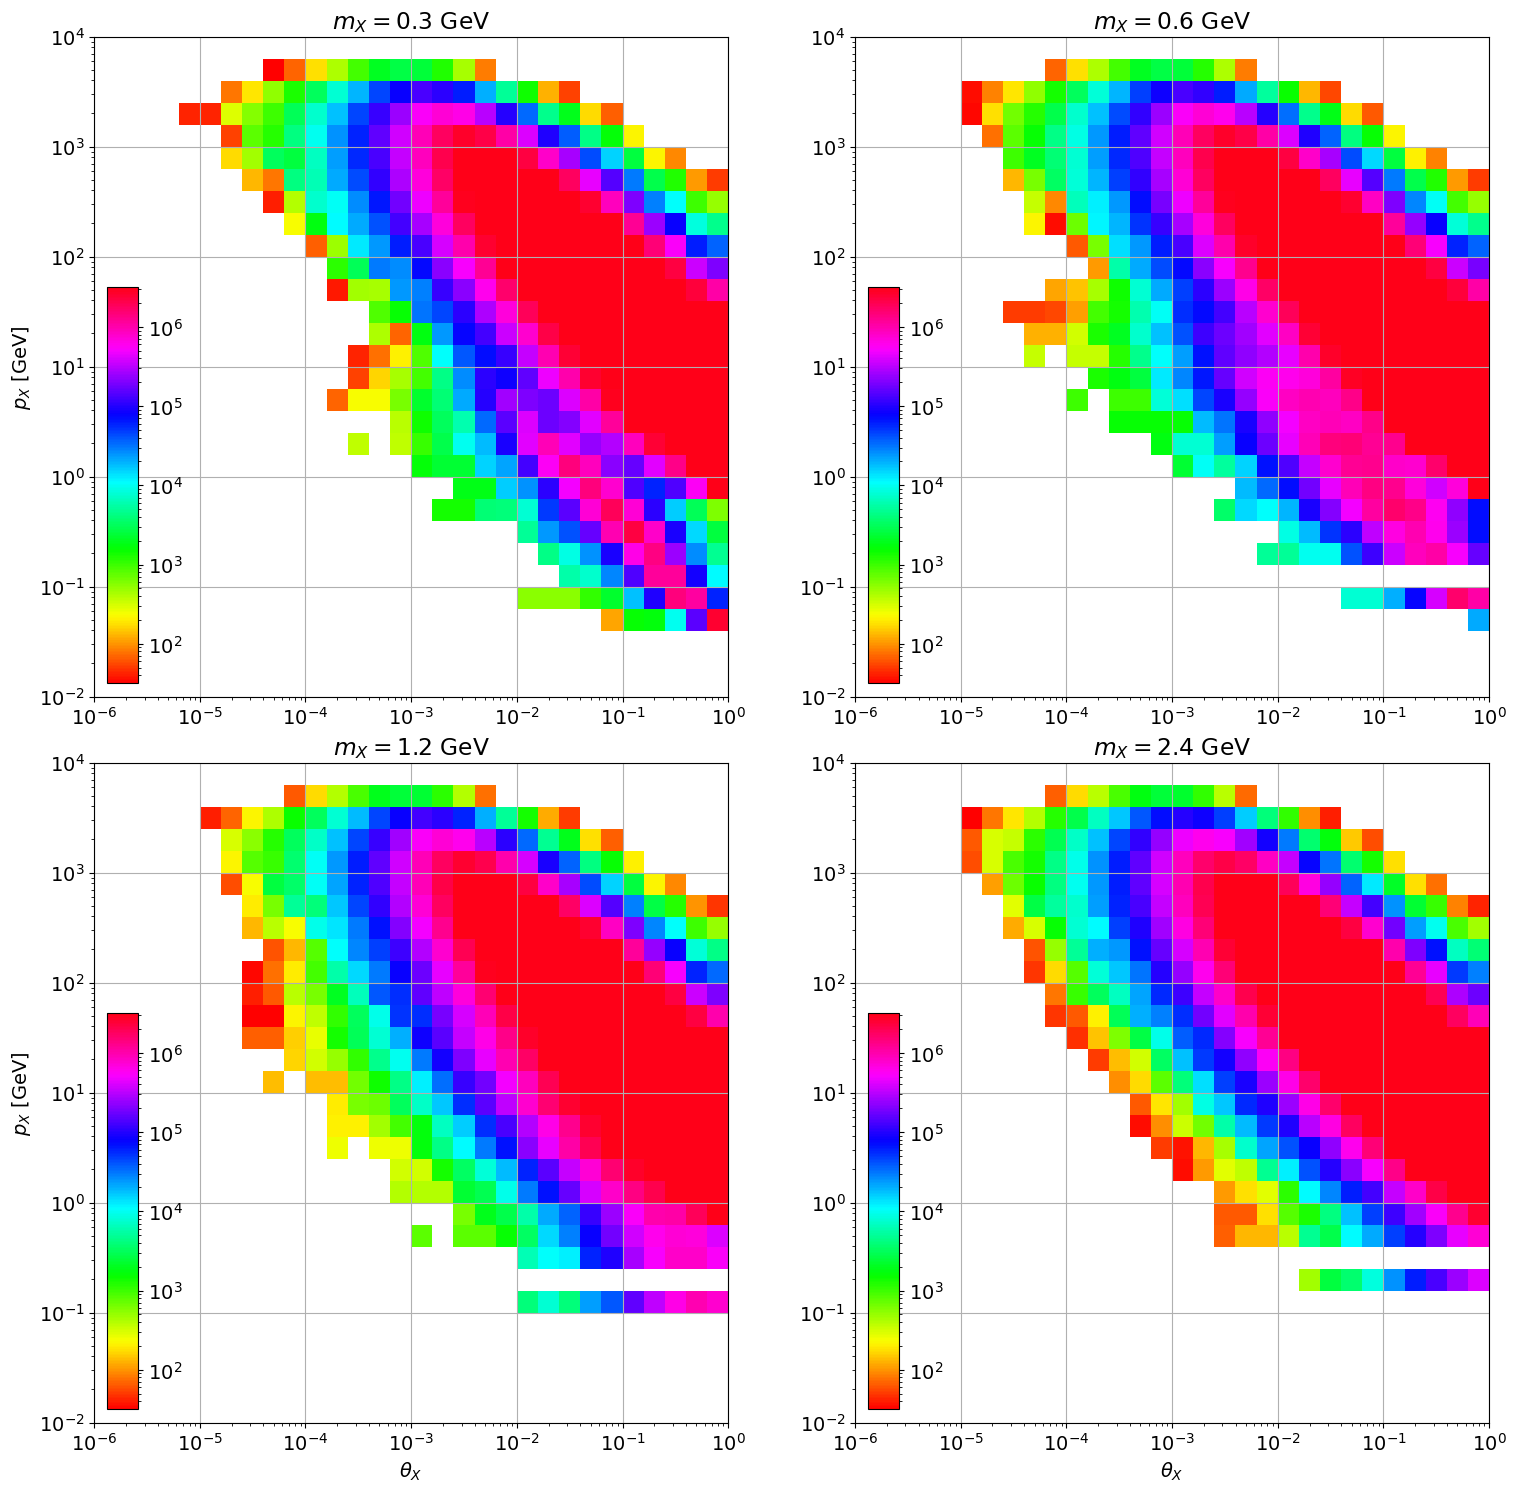

In [11]:
fig = plot_X_spectra([[0.3, 0.6],[1.2, 2.4]]);
fig.savefig('Plots/X_dist.pdf');

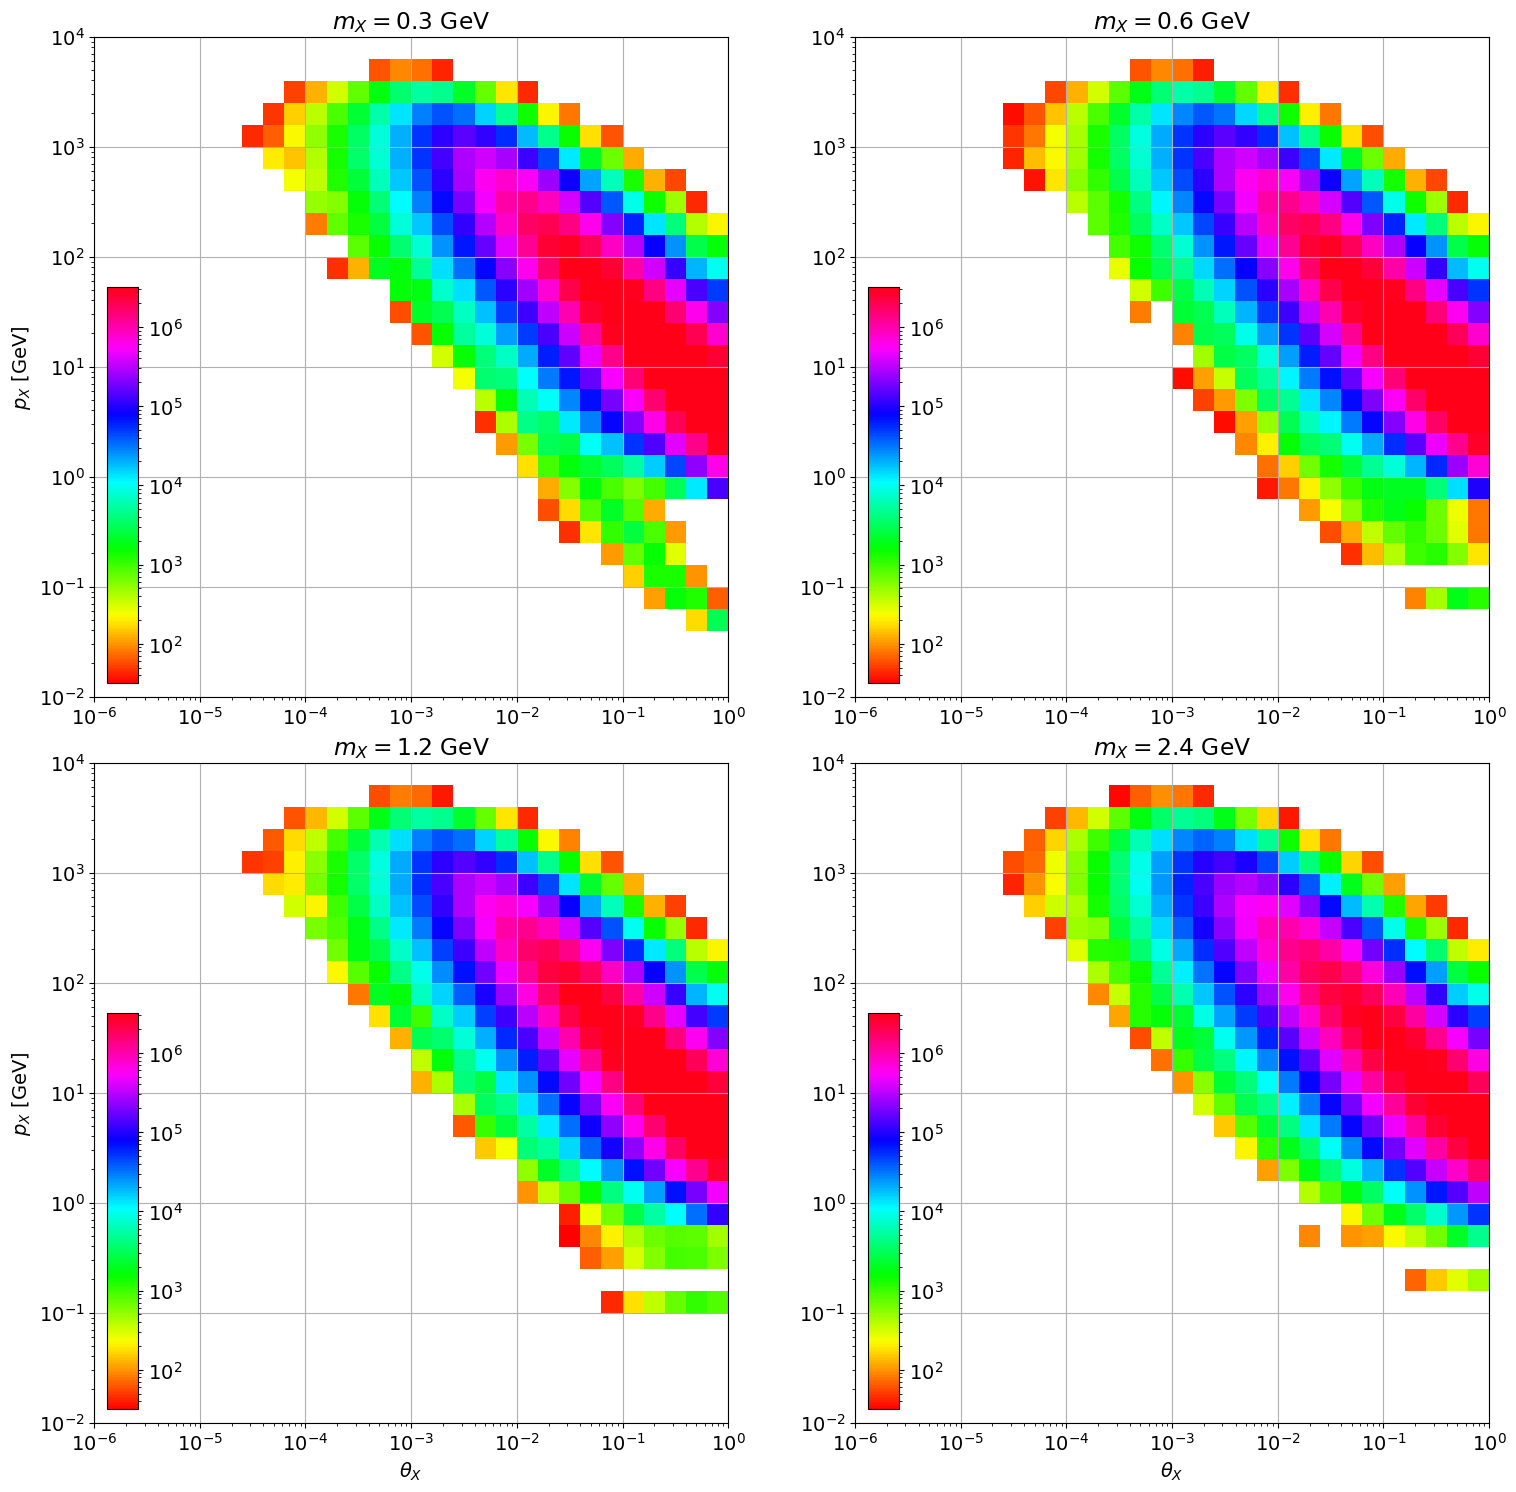

In [12]:
fig = plot_X_spectra([[0.3, 0.6],[1.2, 2.4]], sin_scaled=True);
fig.savefig('Plots/X_dist_angle_scaled.pdf');

### FASER [[1901.04468]](https://arxiv.org/pdf/1901.04468.pdf):

Length to Detector: 480 m \
Decay Volume in Length: 1.5 m \
Decay Volume in Radius: 0.1 m

### FASER2 [[2109.10905]](https://arxiv.org/pdf/2109.10905.pdf):

Length to Detector: 480 m \
Decay Volume in Length: 5 m \
Decay Volume in Radius: 1 m

In [13]:
L_FASER = 480
Delta_FASER = 1.5
R_FASER = 0.1
theta_FASER = R_FASER / L_FASER
lum_FASER = 300 * 10 ** 3 # 300 fb^-1 = 3 * 10 ^ 5 pb^-1

L_FASER2 = 480
Delta_FASER2 = 5
R_FASER2 = 1
theta_FASER2 = R_FASER2 / L_FASER2
lum_FASER2 = 3 * 10 ** 6 # 3 ab^-1 = 3 * 10 ^ 6 pb^-1

L_comp = 400
Delta_comp = 10
R_comp = 1
theta_comp = R_comp / L_comp
lum_comp = 3 * 10 ** 6



In [14]:
def plot_reach_FASER(m_Xs, sin_scaled=False):
    m_Xs = np.array(m_Xs).T
    cmap = matplotlib.colormaps['hsv']
    cmap.set_under('w')
    width = 9
    height = 9
    try:
        nx, ny = np.shape(m_Xs)
    except ValueError:
        m_Xs = np.reshape(m_Xs, ( np.size(m_Xs), 1 ))
        nx, ny = np.shape(m_Xs)

    fig = plt.figure(figsize=(width*nx,2*height*ny))
    plt.subplots_adjust(hspace=0.1)
    
    for i in range(nx):
        for j in range(ny):
            m_X = m_Xs[i,j]
            dataset = np.load('Spectra/X_' + str(m_X) + '_Y_0.497_from_bspectrum.npy')

            p_Bs     = dataset[:,0]
            theta_Bs = dataset[:,1]
            theta_rs = dataset[:,3]
            phi_rs   = dataset[:,4]
            xsecs    = dataset[:,2]
            xsecs_logscaled = xsecs * p_Bs * (theta_Bs * np.log(10) ** 2)

            theta_x = dataset[:,6]
            p_x     = dataset[:,5]
            
            # Branching ratio for dark higgs
            br_factor = f_mubranching(m_X)
            ctaus = f_ctaus(m_X)
            
            xsecs_logscaled = xsecs_logscaled * br_factor
            # xsec to count for 3 ab^-1
            xsecs_logscaled = xsecs_logscaled * 3 * 10 ** 6
            decay_lengths = ( p_x / m_X ) * ctaus
#             prob_FASER   = np.exp( -390   / decay_lengths ) * (1 - np.exp(-Delta_comp   / decay_lengths))
#             prob_FASER2  = np.exp( -L_FASER2  / decay_lengths ) * (1 - np.exp(-Delta_FASER2  / decay_lengths))

            prob_FASER  = Delta_comp / decay_lengths * np.exp(-390 / decay_lengths)
            prob_FASER2 = Delta_FASER2 / decay_lengths * np.exp(-L_FASER2 / decay_lengths)
#             xsecs_logscaled = xsecs * p_x * (theta_x * np.log(10) ** 2)
            if sin_scaled: xsecs_logscaled = xsecs_logscaled * np.sin(theta_rs) / (4 * np.pi)

            y_bins = np.logspace(-2,4,31)
            x_bins = np.logspace(-6,0,31)

            ax = plt.subplot(2*ny, nx, i+ny*j + 1)
            plt.sca(ax)
            plt.hist2d(theta_x, p_x, bins=[x_bins, y_bins],
                           weights = xsecs_logscaled * prob_FASER,
                           cmap=cmap,
                           norm=matplotlib.colors.LogNorm(vmin=10**-0.5, vmax=10**3.5))
            cax = ax.inset_axes([0.02, 0.02, 0.05, 0.6])
            plt.colorbar(cax=cax, ticks=[10**-1, 1, 10**1, 10**2, 10**3])
            plt.xscale('log')
            plt.yscale('log')
#             if j == ny-1: plt.xlabel('$\\theta_X$')
            if i == 0: plt.ylabel('$p_X$ [GeV]')
            plt.title('$m_X = $' + str(m_X) + ' GeV for FASER');
            
            ax = plt.subplot(2*ny, nx, i+ny*j + 1 + nx*ny)
            plt.sca(ax)
            plt.hist2d(theta_x, p_x, bins=[x_bins, y_bins],
                           weights = xsecs_logscaled * prob_FASER2,
                           cmap=cmap,
                           norm=matplotlib.colors.LogNorm(vmin=10**-0.5, vmax=10**3.5))
            cax = ax.inset_axes([0.02, 0.02, 0.05, 0.6])
            plt.colorbar(cax=cax, ticks=[10**-1, 1, 10**1, 10**2, 10**3])
            plt.xscale('log')
            plt.yscale('log')
            if j == ny-1: plt.xlabel('$\\theta_X$')
            if i == 0: plt.ylabel('$p_X$ [GeV]')
            plt.title('$m_X = $' + str(m_X) + ' GeV for FASER2');
    return fig, p_x, decay_lengths, ctaus

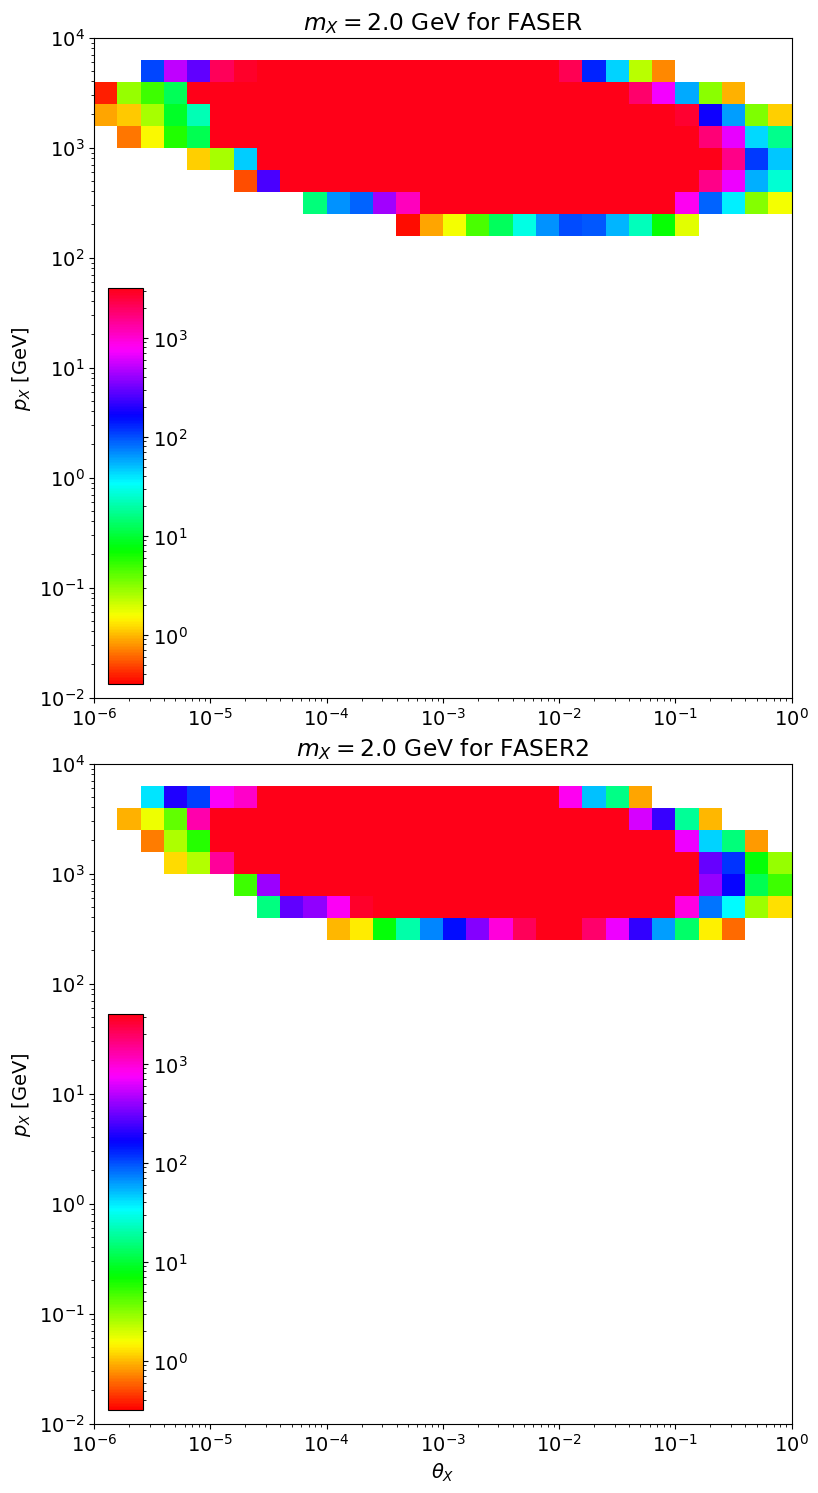

In [15]:
# fig = plot_reach_FASER([[0.3, 0.6, 1.2, 2.4]]);
fig, p_x, decay_lengths, ctaus = plot_reach_FASER([[2.0]], sin_scaled=True);
fig.savefig('Plots/X_probed.pdf');

In [16]:
# Summing
# Fast but remains accurate (?)
def determine_N_events(m_Xs, ctaus):
    N_totals = {}
    N_totals['ctaus'] = ctaus
    for m_X in m_Xs:
        print(' * Loading the m_X = ' + str(m_X) + ' dataset.')
        dataset = np.load('Spectra/X_' + str(m_X) + '_Y_0.497_from_bspectrum.npy')
        print('\n\tProcessing data...')
        p_Bs     = dataset[:,0]
        theta_Bs = dataset[:,1]
        theta_rs = dataset[:,3]
        phi_rs   = dataset[:,4]
        xsecs    = dataset[:,2]
        xsecs_logscaled = xsecs * p_Bs * theta_Bs * np.log(10) ** 2
#         xsecs_logscaled = xsecs_logscaled * np.sin(theta_rs) / (4 * np.pi)

        p     = dataset[:,5] 
        theta = dataset[:,6]

        mask_FASER  = theta < ( R_FASER  / L_FASER  )
        mask_FASER2 = theta < ( R_FASER2 / L_FASER2 )
        mask_comp = theta < (R_comp / L_comp)

        tmp_FASER  = []
        tmp_FASER2 = []
#         tmp_comp   = []

        for ctau in ctaus:
            decay_lengths = ( np.sqrt(p ** 2 + m_X ** 2) / m_X ) * ctau
            prob_FASER  = np.exp( -L_FASER  / decay_lengths ) * (1 - np.exp(-Delta_FASER  / decay_lengths))
            prob_FASER2 = np.exp( -L_FASER2 / decay_lengths ) * (1 - np.exp(-Delta_FASER2 / decay_lengths))
#             prob_comp = np.exp( -L_comp / decay_lengths ) * (1 - np.exp(-Delta_comp / decay_lengths))

            tmp_FASER.append( np.dot(xsecs_logscaled[mask_FASER], prob_FASER[mask_FASER]) * lum_FASER ) 
            tmp_FASER2.append( np.dot(xsecs_logscaled[mask_FASER2], prob_FASER2[mask_FASER2]) * lum_FASER2 )  
#             tmp_comp.append( np.dot(xsecs_logscaled[mask_comp], prob_FASER2[mask_comp]) * lum_comp )  

        N_totals[str(m_X)] = {'FASER' : np.array(tmp_FASER),
                              'FASER2' : np.array(tmp_FASER2)}
#                               'comp' : np.array(tmp_comp)}
        print('\n - Done processing the m_X = ' + str(m_X) + ' dataset.\n\n')
    return N_totals

In [17]:
ctaus = np.logspace(-3,2,26)
m_Xs = [0.3, 0.6, 1.2, 2.4]
N_totals = determine_N_events(m_Xs, ctaus)

 * Loading the m_X = 0.3 dataset.

	Processing data...

 - Done processing the m_X = 0.3 dataset.


 * Loading the m_X = 0.6 dataset.

	Processing data...

 - Done processing the m_X = 0.6 dataset.


 * Loading the m_X = 1.2 dataset.

	Processing data...

 - Done processing the m_X = 1.2 dataset.


 * Loading the m_X = 2.4 dataset.

	Processing data...

 - Done processing the m_X = 2.4 dataset.




In [18]:
# Import Reuven's CHARM and LHCb bounds

cur_dir = 'digitizedplots/'
ls = listdir(cur_dir)

B_constr = {}
for fname in [fname for fname in ls if re.search('\.csv',fname)]:
    args = re.search('^([a-z|A-Z]*)_([0-9]*)',fname)
    exp = args[1]
    mass = float(args[2]) * 10 ** -3
    
    data = np.loadtxt(cur_dir + fname)
    ctaus = data[:,0]
    # CHARM data for m != 1.2 is in picoseconds -> 10 ** -12 seconds
    if not(mass == 1.2): ctaus = ctaus * c * 10 ** -12
    bounds = data[:,1]
    
    if not(str(mass) in B_constr.keys()):
        B_constr[str(mass)] = {}
    
    B_constr[str(mass)][exp] = {
        'ctaus'  : ctaus,
        'Br'     : bounds
    }
    
    if exp == 'CHARM': B_constr[str(mass)][exp]['color'] = 'green'
    if exp == 'LHCb': B_constr[str(mass)][exp]['color'] = 'red'
    

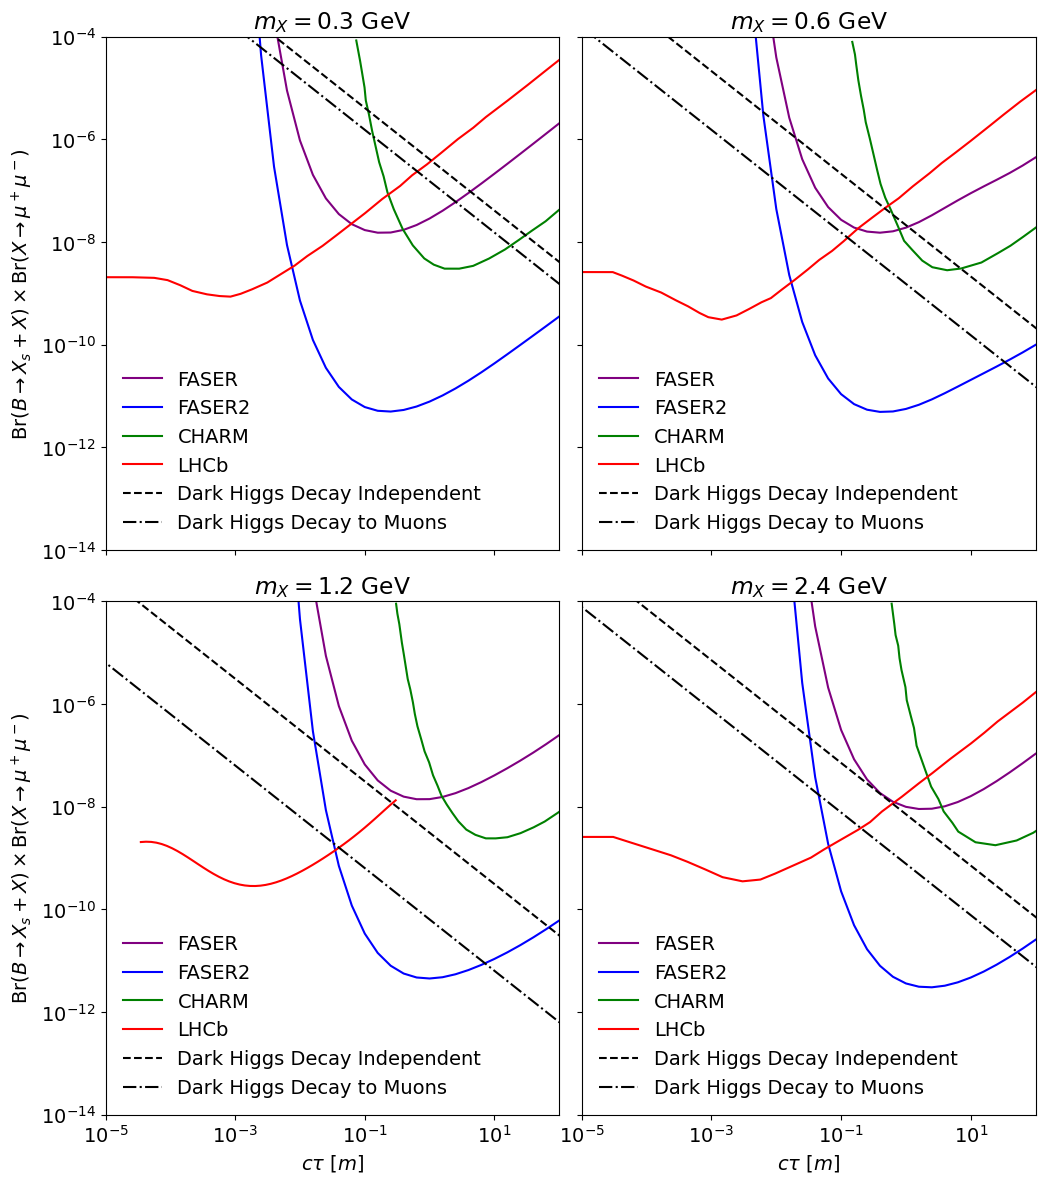

In [19]:
# Make nice axes for plotting
fig, axs = plt.subplots(2,2,sharex=True, sharey=True,
                        gridspec_kw={'wspace' : 0.05, 'hspace' : 0.1}, figsize=(12,14));
N_required = 3

m_Xs = [0.3, 0.6, 1.2, 2.4]
ctau_H = {}
BrXH = {}
for m_X in m_Xs:
    ctau_H[str(m_X)] = f_ctaus(m_X)
    BrXH[str(m_X)] = f_mubranching(m_X)
# BrXH = {'0.3' : 0.3, '0.6' : 0.06, '1.2' : 0.01, '2.4' : 0.1}
for (m_X, ax) in zip(m_Xs,axs.reshape(np.size(axs),)):

    # Br reach for FASER and FASER2
    ctaus = N_totals['ctaus']
    N_FASER  = N_totals[str(m_X)]['FASER']
    N_FASER2 = N_totals[str(m_X)]['FASER2']
#     N_comp = N_totals[str(m_X)]['comp']
    ax.plot(ctaus, N_required / N_FASER, color = 'purple', label = 'FASER')       
    ax.plot(ctaus, N_required / N_FASER2, color = 'blue', label = 'FASER2')
#     ax.fill_between(ctaus, N_required / N_comp, np.ones(np.shape(N_comp)), color = 'yellow', label = 'comp')

#     N_FASER_int  = N_totals_int[str(m_X)]['FASER']
#     N_FASER2_int = N_totals_int[str(m_X)]['FASER2']
#     ax.plot(ctaus, N_required / N_FASER_int, '--', color = 'purple', label = 'FASER integrated')       
#     ax.plot(ctaus, N_required / N_FASER2_int, '--', color = 'blue', label = 'FASER2 integrated')
    
    for exp in sorted(B_constr[str(m_X)].keys()):
        ctaus    = B_constr[str(m_X)][exp]['ctaus']
        bounds   = B_constr[str(m_X)][exp]['Br']
        color    = B_constr[str(m_X)][exp]['color']
        ax.plot(ctaus, bounds, color=color, label=exp)
    
    if m_X == 1.2:
        xlo = np.log10(0.00003505313686224187)
        xhi = np.log10(0.3)
        x = np.logspace(xlo, xhi)
#         LHCb_2015 = np.exp(-16.0285 - 0.597414 * np.log(x) ** 2 - 0.239592 * np.log(x) ** 3 - 
#           0.0535686 * np.log(x) ** 4 - 0.00696911 * np.log(x) ** 5 - 0.000462062 * np.log(x) ** 6 - 
#           0.000011902 * np.log(x) ** 7) * x ** 0.228806
#         ax.plot(x, LHCb_2015, label='LHCb 1508.04094')

        LHCb_2016 = np.exp(-17.7825 - 2.03224 * np.log(x) ** 2 - 0.877746 * np.log(x) ** 3 - 
         0.202081 * np.log(x) ** 4 - 0.0256459 * np.log(x) ** 5 - 0.00164878 * np.log(x) ** 6 - 
         0.0000416377 * np.log(x) ** 7) / (x ** 1.18973)
        ax.plot(x, LHCb_2016, color='red', label='LHCb') # '1612.07818')

    # Line for Dark Higgs via mixing
#     thetas = np.logspace(-8,0,200)
#     gammas = m_mu ** 2 * m_X / (8 * np.pi * v ** 2) * (1 - 4 * m_mu ** 2 / m_X ** 2) ** (3/2) * thetas ** 2
#     ctaus = c * hbar / gammas
#     branches = 5.7 * (1 - m_mu ** 2 / m_X ** 2) ** 2 * thetas ** 2
#     branches_mu = branches * BrXH[str(m_X)]
#     ax.plot(ctaus, branches, 'k--', label = 'Dark Higgs Decay Independent')
#     ax.plot(ctaus, branches_mu, 'k-.', label = 'Dark Higgs Decay to Muons')
    
    # Using numerical data from 1710.09387 and interpolating
    thetas = np.logspace(-8, 0, 200)
    ctaus = ctau_H[str(m_X)] * ((10 ** -4) ** 2) / (thetas ** 2)
    branches = 5.7 * (1 - m_mu ** 2 / m_X ** 2) ** 2 * thetas ** 2
    branches_mu = branches * BrXH[str(m_X)]
    ax.plot(ctaus, branches, 'k--', label = 'Dark Higgs Decay Independent')
    ax.plot(ctaus, branches_mu, 'k-.', label = 'Dark Higgs Decay to Muons')

    ax.set_xlim([10**-5, 10**2])
    ax.set_ylim([10**-14, 10**-4])
    if any(ax == axs[1]):
        ax.set_xlabel('$c\\tau~[m]$')
    if any(ax == axs[:,0]):
        ax.set_ylabel('Br($B\\rightarrow X_s + X) \\times \mathrm{Br}(X\\rightarrow \mu^+\mu^-)$')
    ax.set_title('$m_X=$' + str(m_X) + ' GeV')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(loc='lower left', frameon=False);

fig.savefig('Plots/FASER_comparison.pdf')

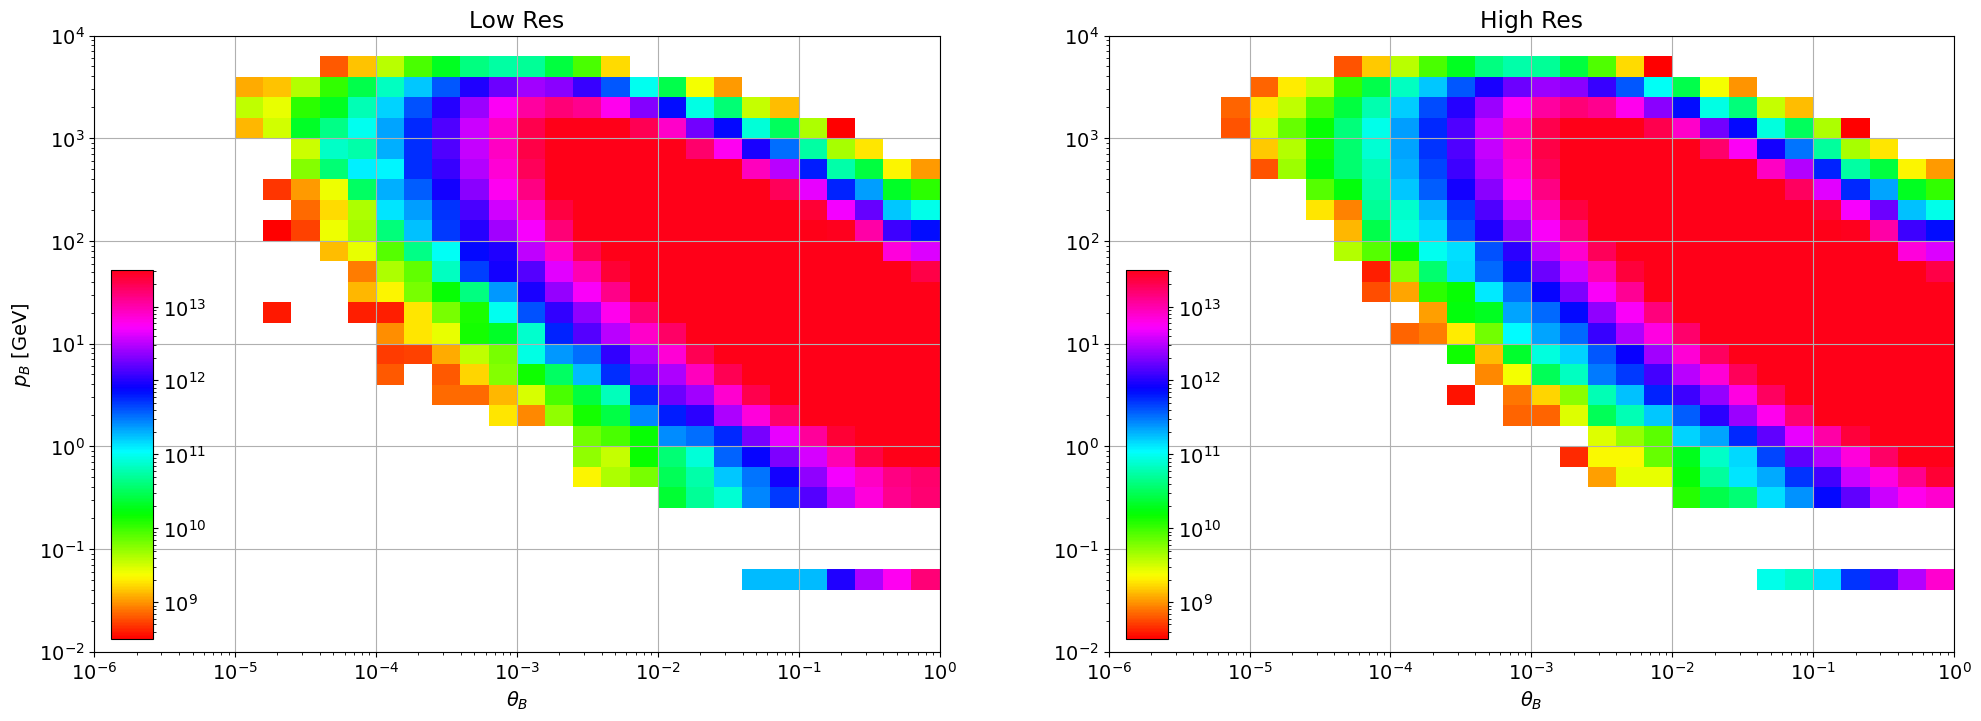

In [20]:
cmap = matplotlib.colormaps['hsv']
cmap.set_under('w')

fig = plt.figure(figsize=(24,8))

dataset1 = np.load('Spectra/X_2.0_Y_0.497_from_bspectrum.npy')
dataset2 = np.load('Spectra/X_2.0_Y_0.497_from_bspectrum_highres.npy')

i=1
datasets = [dataset1, dataset2]
titles = ['Low Res', 'High Res']
for (dataset, title) in zip(datasets, titles):
    p_Bs   = dataset[:,0]
    thetas = dataset[:,1]
    p_Xs     = dataset[:,5]
    theta_Xs = dataset[:,6]
    xsecs  = dataset[:,2]
    xsecs_logscaled = xsecs * p_Bs * thetas * np.log(10) ** 2
    if i == 3:
        theta_rs = dataset[:,3]
        phi_rs   = dataset[:,4]
        xsecs_logscaled = xsecs * p_Bs * thetas * np.log(10) ** 2
#         xsecs_logscaled = xsecs_logscaled * theta_rs * phi_rs * np.log(10) ** 2
        xsecs_logscaled = xsecs_logscaled * np.sin(theta_rs) / 2
    xsecs_logscaled = xsecs_logscaled * 3 * 10 ** 6 # 3 ab^{-1} / pb^{-1}
    p_Bs_u   = np.sort(list(set(p_Bs)))
    thetas_u = np.sort(list(set(thetas)))

    p_bins = np.logspace(-2,4,31)
    theta_bins = np.logspace(-6,0,31)

    ax = plt.subplot(1,len(datasets),i)
    plt.sca(ax)
    plt.hist2d(theta_Xs, p_Xs, bins=[theta_bins, p_bins],
               weights = xsecs_logscaled,
               cmap=cmap,
               norm=matplotlib.colors.LogNorm(vmin=10**8.5,vmax=10**13.5))
    cax = ax.inset_axes([0.02, 0.02, 0.05, 0.6])
    plt.colorbar(cax=cax)
    plt.xscale('log')
    plt.yscale('log')
    plt.grid();
    plt.title(title)
    plt.xlabel('$\\theta_B$')
    if i == 1: plt.ylabel('$p_B$ [GeV]')
    i += 1

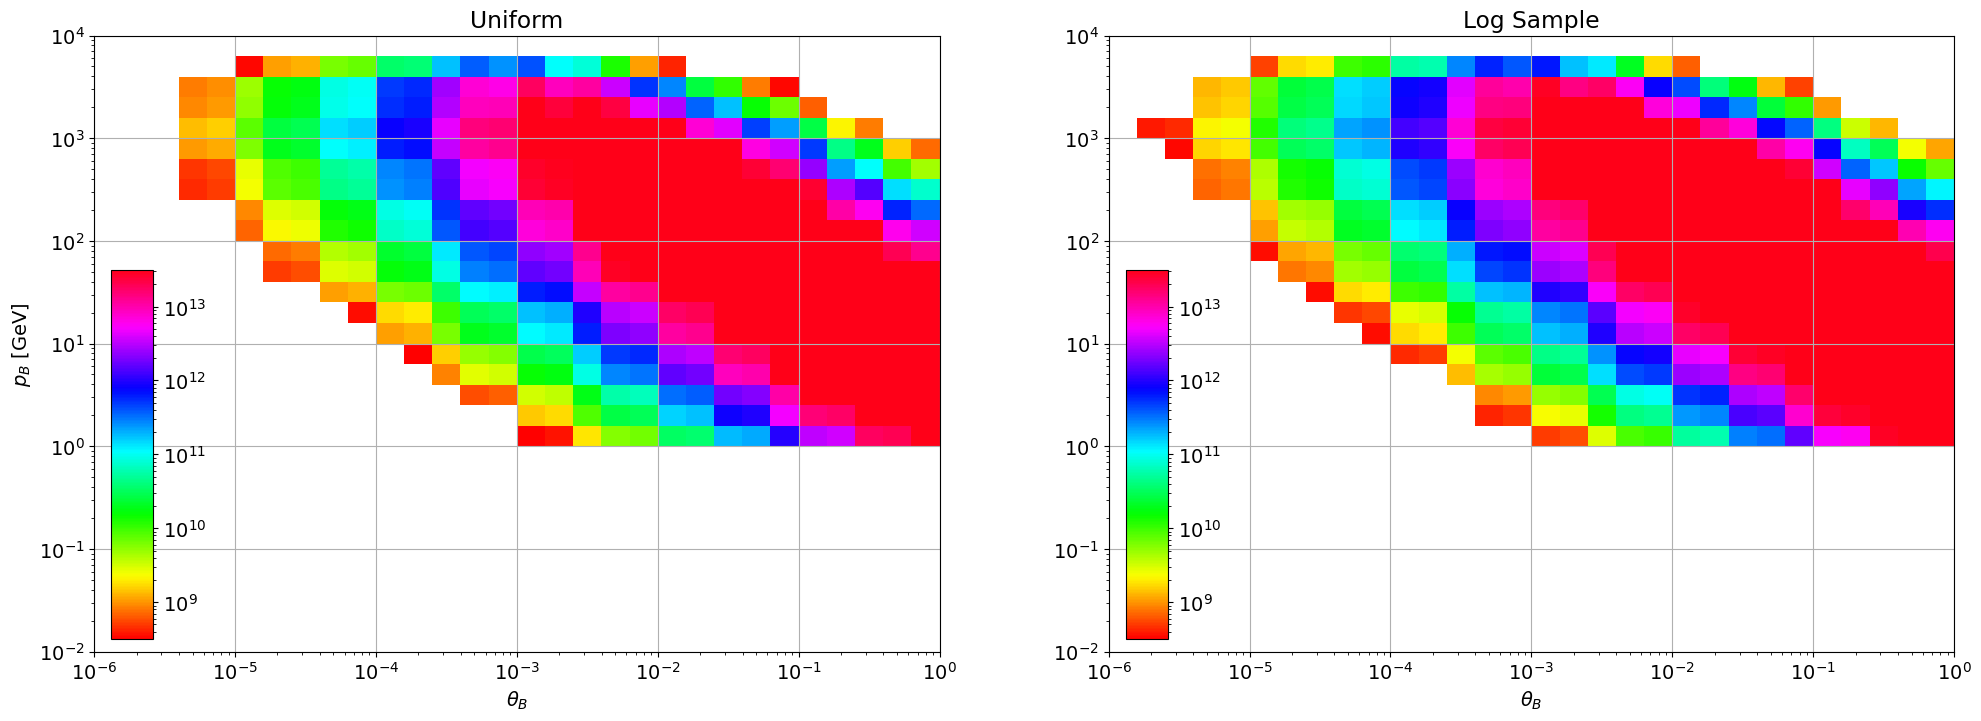

In [23]:
cmap = matplotlib.colormaps['hsv']
cmap.set_under('w')

fig = plt.figure(figsize=(24,8))

dataset1 = np.load('Spectra/X_2.0_Y_0.497_from_bspectrum.npy')
dataset2 = np.load('Spectra/X_2.0_Y_0.497_from_bspectrum_logsample.npy')

i=1
datasets = [dataset1, dataset2]
titles = ['Uniform', 'Log Sample']
for (dataset, title) in zip(datasets, titles):
    p_Bs   = dataset[:,0]
    thetas = dataset[:,1]
    p_Xs     = dataset[:,5]
    theta_Xs = dataset[:,6]
    xsecs  = dataset[:,2]
    xsecs_logscaled = xsecs * p_Bs * thetas * np.log(10) ** 2
    if i == 2:
        theta_rs = dataset[:,3]
        phi_rs   = dataset[:,4]
        xsecs_logscaled = xsecs * p_Bs * thetas * np.log(10) ** 2
        xsecs_logscaled = xsecs_logscaled * theta_rs
    xsecs_logscaled = xsecs_logscaled * 3 * 10 ** 6 # 3 ab^{-1} / pb^{-1}
    p_Bs_u   = np.sort(list(set(p_Bs)))
    thetas_u = np.sort(list(set(thetas)))

    p_bins = np.logspace(-2,4,31)
    theta_bins = np.logspace(-6,0,31)

    ax = plt.subplot(1,len(datasets),i)
    plt.sca(ax)
    plt.hist2d(thetas, p_Bs, bins=[theta_bins, p_bins],
               weights = xsecs_logscaled,
               cmap=cmap,
               norm=matplotlib.colors.LogNorm(vmin=10**8.5,vmax=10**13.5))
    cax = ax.inset_axes([0.02, 0.02, 0.05, 0.6])
    plt.colorbar(cax=cax)
    plt.xscale('log')
    plt.yscale('log')
    plt.grid();
    plt.title(title)
    plt.xlabel('$\\theta_B$')
    if i == 1: plt.ylabel('$p_B$ [GeV]')
    i += 1